In [ ]:
!pip install pytorch-tabnet
!pip install wget
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path


%load_ext autoreload

%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train = pd.read_csv('data.csv')

In [ ]:
target = 'order_id'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
dataset_name = 'electronics-store'

In [ ]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Set 3


In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

In [ ]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
n_targets = 8

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [ ]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: inf     | train_rmsle: 1523.71064| train_mae: 2.348720000000124e+18| train_rmse: 2.348720000000055e+18| train_mse: 5.516485638400257e+36| valid_rmsle: 1524.17249| valid_mae: 2.3487200000000133e+18| valid_rmse: 2.34872000000001e+18| valid_mse: 5.516485638400049e+36|  0:00:00s
epoch 1  | loss: nan     | train_rmsle: 1543.22922| train_mae: 2.348720000000126e+18| train_rmse: 2.348720000000055e+18| train_mse: 5.516485638400258e+36| valid_rmsle: 1542.88848| valid_mae: 2.348720000000031e+18| valid_rmse: 2.348720000000011e+18| valid_mse: 5.516485638400051e+36|  0:00:00s
epoch 2  | loss: nan     | train_rmsle: 1409.82136| train_mae: 2.348720000000122e+18| train_rmse: 2.348720000000055e+18| train_mse: 5.516485638400257e+36| valid_rmsle: 1413.17313| valid_mae: 2.3487199999999985e+18| valid_rmse: 2.348720000000009e+18| valid_mse: 5.516485638400044e+36|  0:00:00s
epoch 3  | loss: nan     | train_rmsle: 1335.46277| train_mae: 2.34872000000012e+18| train_rmse: 2.348720000000055e+18| 

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
preds = clf.predict(X_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_mse}")

BEST VALID SCORE FOR electronics-store : 5.516485638400037e+36
FINAL TEST SCORE FOR electronics-store : 5.516485638400028e+36


In [ ]:
clf.feature_importances_

array([8.27225931e-02, 9.16773515e-01, 5.03891988e-04])

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

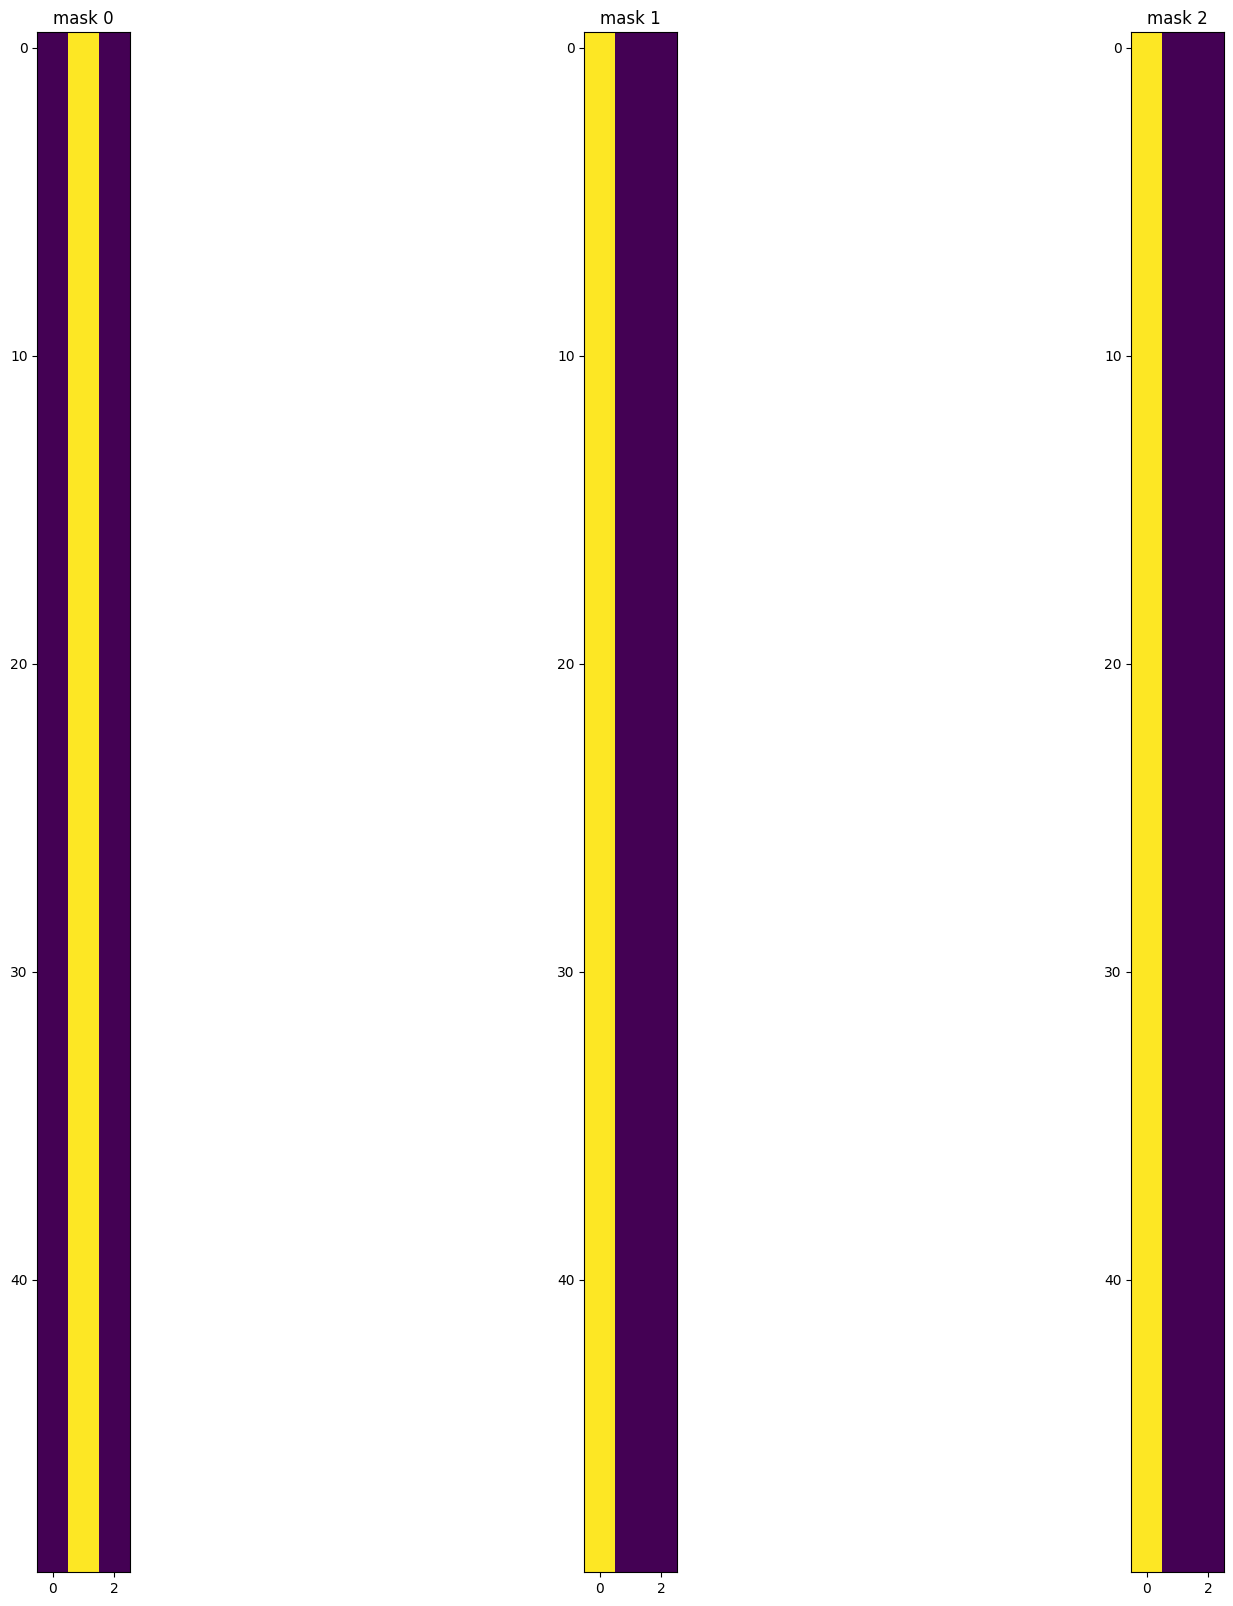

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")